In [1147]:
import glob
# This file should run basically insta fast. Bad coding for sure 
# There is a place where i sometimes comment out lin/rbf/sigmoid stuff
# Dont do that, it really helps for some subjects. 
# Anything. Leave only linear. For fast testing of best features
# But dont do that either. 
import os
saveFolderName = "peak"
genSavePath = f"{os.getcwd()}/SavedResults/"
day = "29" # Which month and days result you want to visualize in table
month = 11

featureName = "udrlI"
cmbSize = 2
repetitionValue = 24
featureSelect = "OnlySepOnlyCurr01th"
repetitionName = f"{featureName}{cmbSize}c{featureSelect}" #"debuggingOnlyCurrthreeAv2correct" #"debuggingOnlyPreNotCurrthreeAv2Correct"# "testAvgDoubleBC4labelsinner2c" # "testAvgDoubleBC4labels1c" # #"peak4-const3-i-ud-global-10-3c"  # "i-ud-global-05-2c" # # "withFixedButWorse3"# #  "udrli1feattestanglnoBC"  # "udrliplotnoAda3"  #  "udrlBC4CVTest" # 
#  "udrliplotnoAda3hyperparams" 
repetitionString = f"{repetitionValue}{repetitionName}"
curSavePath = f"{genSavePath}{day}-{month}-{repetitionString}/"
savedResults = glob.glob(curSavePath + "savedBest*")

saveTop = True

if saveTop:
    saveTopName = f"top{cmbSize}{featureName}.npy"
else:
    saveTopName = None
topAmount = 20
skipSubjects = []
onlySignificant = True
minAcc = 0.0
print(len(savedResults))
print(len(savedResults)/9)


6
0.6666666666666666


In [1148]:
import pandas as pd
from array import ArrayType
from requests import delete
import numpy as np


nameDict = dict()
nrOfNames = 0
kernelDict = dict()
nrOfKernel = 0

currSeed = 0
currSubj = 0
combinationList = []

testInfoPerSubject = [None] * 10

results = []
for path in savedResults:
    results.append(np.load(path, allow_pickle=True))

subjectAmount = 10
    
for subject in results:
    currSubj = subject[1]
    testInfoPerSubject[currSubj] = subject[0]
soloFeatures = []
featCombos = []
kernels = testInfoPerSubject[1][2][0]
regValues = testInfoPerSubject[1][2][1]
paradigmName = testInfoPerSubject[1][3]
for subinfo in testInfoPerSubject[1:]:
    if subinfo is None:
        continue
    subSoloFeatures = subinfo[0]
    subfeatCombos = subinfo[1]
    for featCombo in subinfo[1]:
        if featCombo not in featCombos:
            featCombos.append(featCombo)
    # if len(soloFeatures) < len(subSoloFeatures):
    #     soloFeatures = subSoloFeatures
    # if len(featCombos) < len(subfeatCombos):
    #     featCombos = subfeatCombos



    #print(subinfo)
allCombinations = []
comboNumber = 0
combinationDict = dict()
for featCombo in featCombos:
    for kernel in kernels:
        for regValue in regValues:
            allCombinations.append([featCombo, kernel, regValue, comboNumber])
            combinationDict[f"{featCombo},{kernel},{regValue}"] = comboNumber
            comboNumber = comboNumber + 1
#print(combinationDict)
timesPerCombo = np.zeros([comboNumber])
nrOfCombination = len(allCombinations)
combinationResult = np.zeros([subjectAmount, len(allCombinations), 2])
combinationAmounts = np.zeros([subjectAmount, len(allCombinations)])
#print(combinationDict)
nrOfSeedsPerSubject = np.zeros(subjectAmount)
seedCounted = np.zeros([subjectAmount, len(allCombinations), 20])
currSeed = -1
for s, subject in enumerate(results):
    currSubj = 0
    
    subjectBestArray = np.empty([len(subject)], dtype=object)

    
    currSubj = subject[1]
    # print(currSubj)
    # if currSubj == 1:
    #     currSeed = currSeed + 1 
    testInfoPerSubject[currSubj] = subject[0]
    if currSubj in skipSubjects:
        continue
    nrOfSeedsPerSubject[currSubj] += 1

    for aResults in subject[2]:
        for aResults2 in aResults:
            # If the np array comes from svm results
            if len(aResults2) < 10:
                
                aName = aResults2[0]
                ares = aResults2[1]
                akernel = aResults2[2]
                # print(ares)
                aC = aResults2[3]
                # if combinationDict.get(f"{aName},{akernel},{aC}") == None:
                #     combinationDict.get[f"{aName},{akernel},{aC}"] = comboNumber
                #     comboNumber = comboNumber + 1
                timesPerCombo[combinationDict[f"{aName},{akernel},{aC}"]] = timesPerCombo[combinationDict[f"{aName},{akernel},{aC}"]]  + 1
                if combinationDict.get(f"{aName},{akernel},{aC}") is not None:
                    combinationResult[currSubj, combinationDict[f"{aName},{akernel},{aC}"]] = [int(combinationDict[f"{aName},{akernel},{aC}"]), 
                                                                                           combinationResult[currSubj, combinationDict[f"{aName},{akernel},{aC}"]][1] + ares]
                # print(combinationDict[f"{aName},{akernel},{aC}"])

for subNr, subj in enumerate(combinationResult[1:], 1):

    combinationResult[subNr,:, 1] = combinationResult[subNr,:, 1] / nrOfSeedsPerSubject[subNr]

    if "MLP" in kernels:
        combinationResult[subNr,:, 1] = combinationResult[subNr,:, 1] / 2

# timesPerCombo = timesPerCombo/len(savedResults)

# combinationResult[:,:,1] = combinationResult[:,:,1] / timesPerCombo


headers = np.arange(nrOfCombination)
subjectResultArray = np.empty([10, nrOfCombination], dtype=object)
subjectNrList = []

comboAverage = np.zeros([1, nrOfCombination])
comboTotal = np.zeros([1, nrOfCombination])
nrOfSubjects = np.zeros(nrOfCombination)

topTen = []
topThreeAllSubjects = []
topPerFeature = np.zeros([10, len(featCombos)])
allCombinations = np.array(allCombinations)
lowestTopRes = [0, 0]
for subNr, cResult in enumerate(combinationResult):
    topThreeThisSubject = []
    resArray = np.zeros([nrOfCombination])
    if len(cResult) != 0:
        for res in cResult:
            # if res[1]>0.99:
            #     print(res[1])
            #     res[1] = res[1] / 2
            #     print(res[1])
                
            # print(res[0])
            cmbNr = int(res[0])
            # print(cmbNr)
            #print(cmbNr)
            if onlySignificant == True:
                if res[1] < minAcc:
                    continue
            comboAverage[0, cmbNr] = comboAverage[0, cmbNr] + res[1]
            comboTotal[0, cmbNr] = comboTotal[0, cmbNr] + res[1]
            nrOfSubjects[cmbNr] += 1
            
            subjectResultArray[subNr, cmbNr] = res[1]
            comboName = allCombinations[cmbNr][0]
            
            nameIndex = [i for i, elem in enumerate(featCombos) if comboName == elem][0]
            # print(comboName)
            #print(nameIndex)
            #print(featCombos[nameIndex])
   
            if res[1] > topPerFeature[subNr, nameIndex]:
                topPerFeature[subNr, nameIndex] = res[1]

            if len(topTen) < 10 or topTen[0][0] < res[1]:

                if len(topTen) == 10:
                    topTen.reverse()
                    topTen.pop()

                dataF = allCombinations[cmbNr][0]
                kernel =  allCombinations[cmbNr][1]
                cVal =  allCombinations[cmbNr][2]
                topTen.append([res[1], subNr, dataF, kernel, cVal])
                topTen.sort()
            
            if len(topThreeThisSubject) < 2 or topThreeThisSubject[0][0] < res[1]:

                if len(topThreeThisSubject) == 2:
                    topThreeThisSubject.reverse()
                    topThreeThisSubject.pop()
                dataF = allCombinations[cmbNr][0]
                kernel =  allCombinations[cmbNr][1]
                cVal =  allCombinations[cmbNr][2]
                topThreeThisSubject.append([res[1], subNr, dataF, kernel, cVal])
                topThreeThisSubject.sort()
    if len(topThreeThisSubject)>0:
        topThreeAllSubjects.append(topThreeThisSubject)
        
        
        
# Print the table!
comboAverage = comboAverage / nrOfSubjects
pd.set_option("display.max_columns", None)

# For loop through zip of headers and columns,
# If column has all values == None, Remove column and header.
subjectResultArray = np.array(subjectResultArray)
emptyCols = []
atleastOneEmpty = False
for hcol, in zip(headers):
    if all(subjectResultArray[:,hcol] == None):
        atleastOneEmpty = True
        emptyCols.append(hcol)
if atleastOneEmpty: 
    subjectResultArray = np.delete(subjectResultArray, np.array(emptyCols),1)
    headers = np.delete(headers, np.array(emptyCols),0)
    comboAverage = np.delete(comboAverage, np.array(emptyCols),1)
    comboTotal = np.delete(comboTotal, np.array(emptyCols),1)
    nrOfSubjects = np.delete(nrOfSubjects, np.array(emptyCols),0)


table = pd.DataFrame(subjectResultArray, columns=headers)
display(table)




/tmp/ipykernel_81727/3697272359.py:102: RuntimeWarning: invalid value encountered in true_divide
  combinationResult[subNr,:, 1] = combinationResult[subNr,:, 1] / nrOfSeedsPerSubject[subNr]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263
0,0.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,0.0,0.275,0.175,0.25,0.275,0.15,0.175,0.15,0.15,0.225,0.2,0.25,0.2,0.2,0.225,0.3,0.375,0.375,0.275,0.2,0.3,0.225,0.25,0.2,0.275,0.3,0.225,0.175,0.1,0.125,0.25,0.225,0.25,0.275,0.3,0.275,0.275,0.25,0.325,0.325,0.225,0.25,0.225,0.175,0.2,0.225,0.275,0.2,0.25,0.275,0.275,0.275,0.325,0.4,0.2,0.2,0.2,0.325,0.4,0.25,0.275,0.2,0.3,0.3,0.325,0.3,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,0.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0.270833,0.291667,0.25,0.25,0.270833,0.3125,0.208333,0.270833,0.29166

In [1149]:
pd.set_option("display.max_columns", None)
print()
nameDictNrs = np.ones([1, len(nameDict)])
nameDictNrs[0,:] = np.arange(len(nameDict)) * 3
table = pd.DataFrame(topPerFeature, columns=featCombos)
display(table)


,stftDatapeakTime4SortedSep14_&_stftData_BClateTimeSortedSep14,stftData_BCpeakTime4SortedSep14_&_stftData_BClateTimeSortedSep14,stftData_CVpeakTime4SortedSep14_&_stftData_BClateTimeSortedSep14,stftData_CV_BCpeakTime4SortedSep14_&_stftData_BClateTimeSortedSep14,stftData_GRpeakTime4SortedSep14_&_stftData_BClateTimeSortedSep14,stftData_GR_BCpeakTime4SortedSep14_&_stftData_BClateTimeSortedSep14,stftData_GR_CVpeakTime4SortedSep14_&_stftData_BClateTimeSortedSep14,stftDataconstTimeSortedSep14_&_stftData_BClateTimeSortedSep14,stftData_BCconstTimeSortedSep14_&_stftData_BClateTimeSortedSep14,stftData_CVconstTimeSortedSep14_&_stftData_BClateTimeSortedSep14,stftData_CV_BCconstTimeSortedSep14_&_stftData_BClateTimeSortedSep14,stftData_GRconstTimeSortedSep14_&_stftData_BClateTimeSortedSep14,stftData_GR_BCconstTimeSortedSep14_&_stftData_BClateTimeSortedSep14,stftData_GR_CVconstTimeSortedSep14_&_stftData_BClateTimeSortedSep14,stftData_GR_CV_BCconstTimeSortedSep14_&_stftData_BClateTimeSortedSep14,stftDatalateTimeSortedSep14_&_stftData_BClateTimeSortedSep14,stftData_CVlateTimeSortedSep14_&_stftData_BClateTimeSortedSep14,stftData_CV_BClateTimeSortedSep14_&_stftData_BClateTimeSortedSep14,stftData_GRlateTimeSortedSep14_&_stftData_BClateTimeSortedSep14,stftData_GR_BClateTimeSortedSep14_&_stftData_BClateTimeSortedSep14,stftData_GR_CVlateTimeSortedSep14_&_stftData_BClateTimeSortedSep14,stftData_GR_CV_BClateTimeSortedSep14_&_stftData_BClateTimeSortedSep14,stftData_BCpeakTime4SortedSep14_&_stftDatapeakTime4SortedSep14,stftData_CVpeakTime4SortedSep14_&_stftDatapeakTime4SortedSep14,stftData_CV_BCpeakTime4SortedSep14_&_stftDatapeakTime4SortedSep14,stftData_GRpeakTime4SortedSep14_&_stftDatapeakTime4SortedSep14,stftData_GR_BCpeakTime4SortedSep14_&_stftDatapeakTime4SortedSep14,stftData_GR_CVpeakTime4SortedSep14_&_stftDatapeakTime4SortedSep14,stftDataconstTimeSortedSep14_&_stftDatapeakTime4SortedSep14,stftData_BCconstTimeSortedSep14_&_stftDatapeakTime4SortedSep14,stftData_CVconstTimeSortedSep14_&_stftDatapeakTime4SortedSep14,stftData_CV_BCconstTimeSortedSep14_&_stftDatapeakTime4SortedSep14,stftData_GRconstTimeSortedSep14_&_stftDatapeakTime4SortedSep14,stftData_GR_BCconstTimeSortedSep14_&_stftDatapeakTime4SortedSep14,stftData_GR_CVconstTimeSortedSep14_&_stftDatapeakTime4SortedSep14,stftData_GR_CV_BCconstTimeSortedSep14_&_stftDatapeakTime4SortedSep14,stftDatalateTimeSortedSep14_&_stftDatapeakTime4SortedSep14,stftData_BClateTimeSortedSep14_&_stftDatapeakTime4SortedSep14,stftData_CVlateTimeSortedSep14_&_stftDatapeakTime4SortedSep14,stftData_CV_BClateTimeSortedSep14_&_stftDatapeakTime4SortedSep14,stftData_GRlateTimeSortedSep14_&_stftDatapeakTime4SortedSep14,stftData_GR_BClateTimeSortedSep14_&_stftDatapeakTime4SortedSep14,stftData_GR_CVlateTimeSortedSep14_&_stftDatapeakTime4SortedSep14,stftData_GR_CV_BClateTimeSortedSep14_&_stftDatapeakTime4SortedSep14,stftDatapeakTime4SortedSep14_&_stftData_BCconstTimeSortedSep14,stftData_BCpeakTime4SortedSep14_&_stftData_BCconstTimeSortedSep14,stftData_CVpeakTime4SortedSep14_&_stftData_BCconstTimeSortedSep14,stftData_CV_BCpeakTime4SortedSep14_&_stftData_BCconstTimeSortedSep14,stftData_GRpeakTime4SortedSep14_&_stftData_BCconstTimeSortedSep14,stftData_GR_BCpeakTime4SortedSep14_&_stftData_BCconstTimeSortedSep14,stftData_GR_CVpeakTime4SortedSep14_&_stftData_BCconstTimeSortedSep14,stftDataconstTimeSortedSep14_&_stftData_BCconstTimeSortedSep14,stftData_CVconstTimeSortedSep14_&_stftData_BCconstTimeSortedSep14,stftData_CV_BCconstTimeSortedSep14_&_stftData_BCconstTimeSortedSep14,stftData_GRconstTimeSortedSep14_&_stftData_BCconstTimeSortedSep14,stftData_GR_BCconstTimeSortedSep14_&_stftData_BCconstTimeSortedSep14,stftData_GR_CVconstTimeSortedSep14_&_stftData_BCconstTimeSortedSep14,stftData_GR_CV_BCconstTimeSortedSep14_&_stftData_BCconstTimeSortedSep14,stftDatalateTimeSortedSep14_&_stftData_BCconstTimeSortedSep14,stftData_BClateTimeSortedSep14_&_stftData_BCconstTimeSortedSep14,stftData_CVlateTimeSortedSep14_&_stftData_BCconstTimeSortedSep14,s

In [1150]:
for x in timesPerCombo:
    print(x)

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
3.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


(88,)




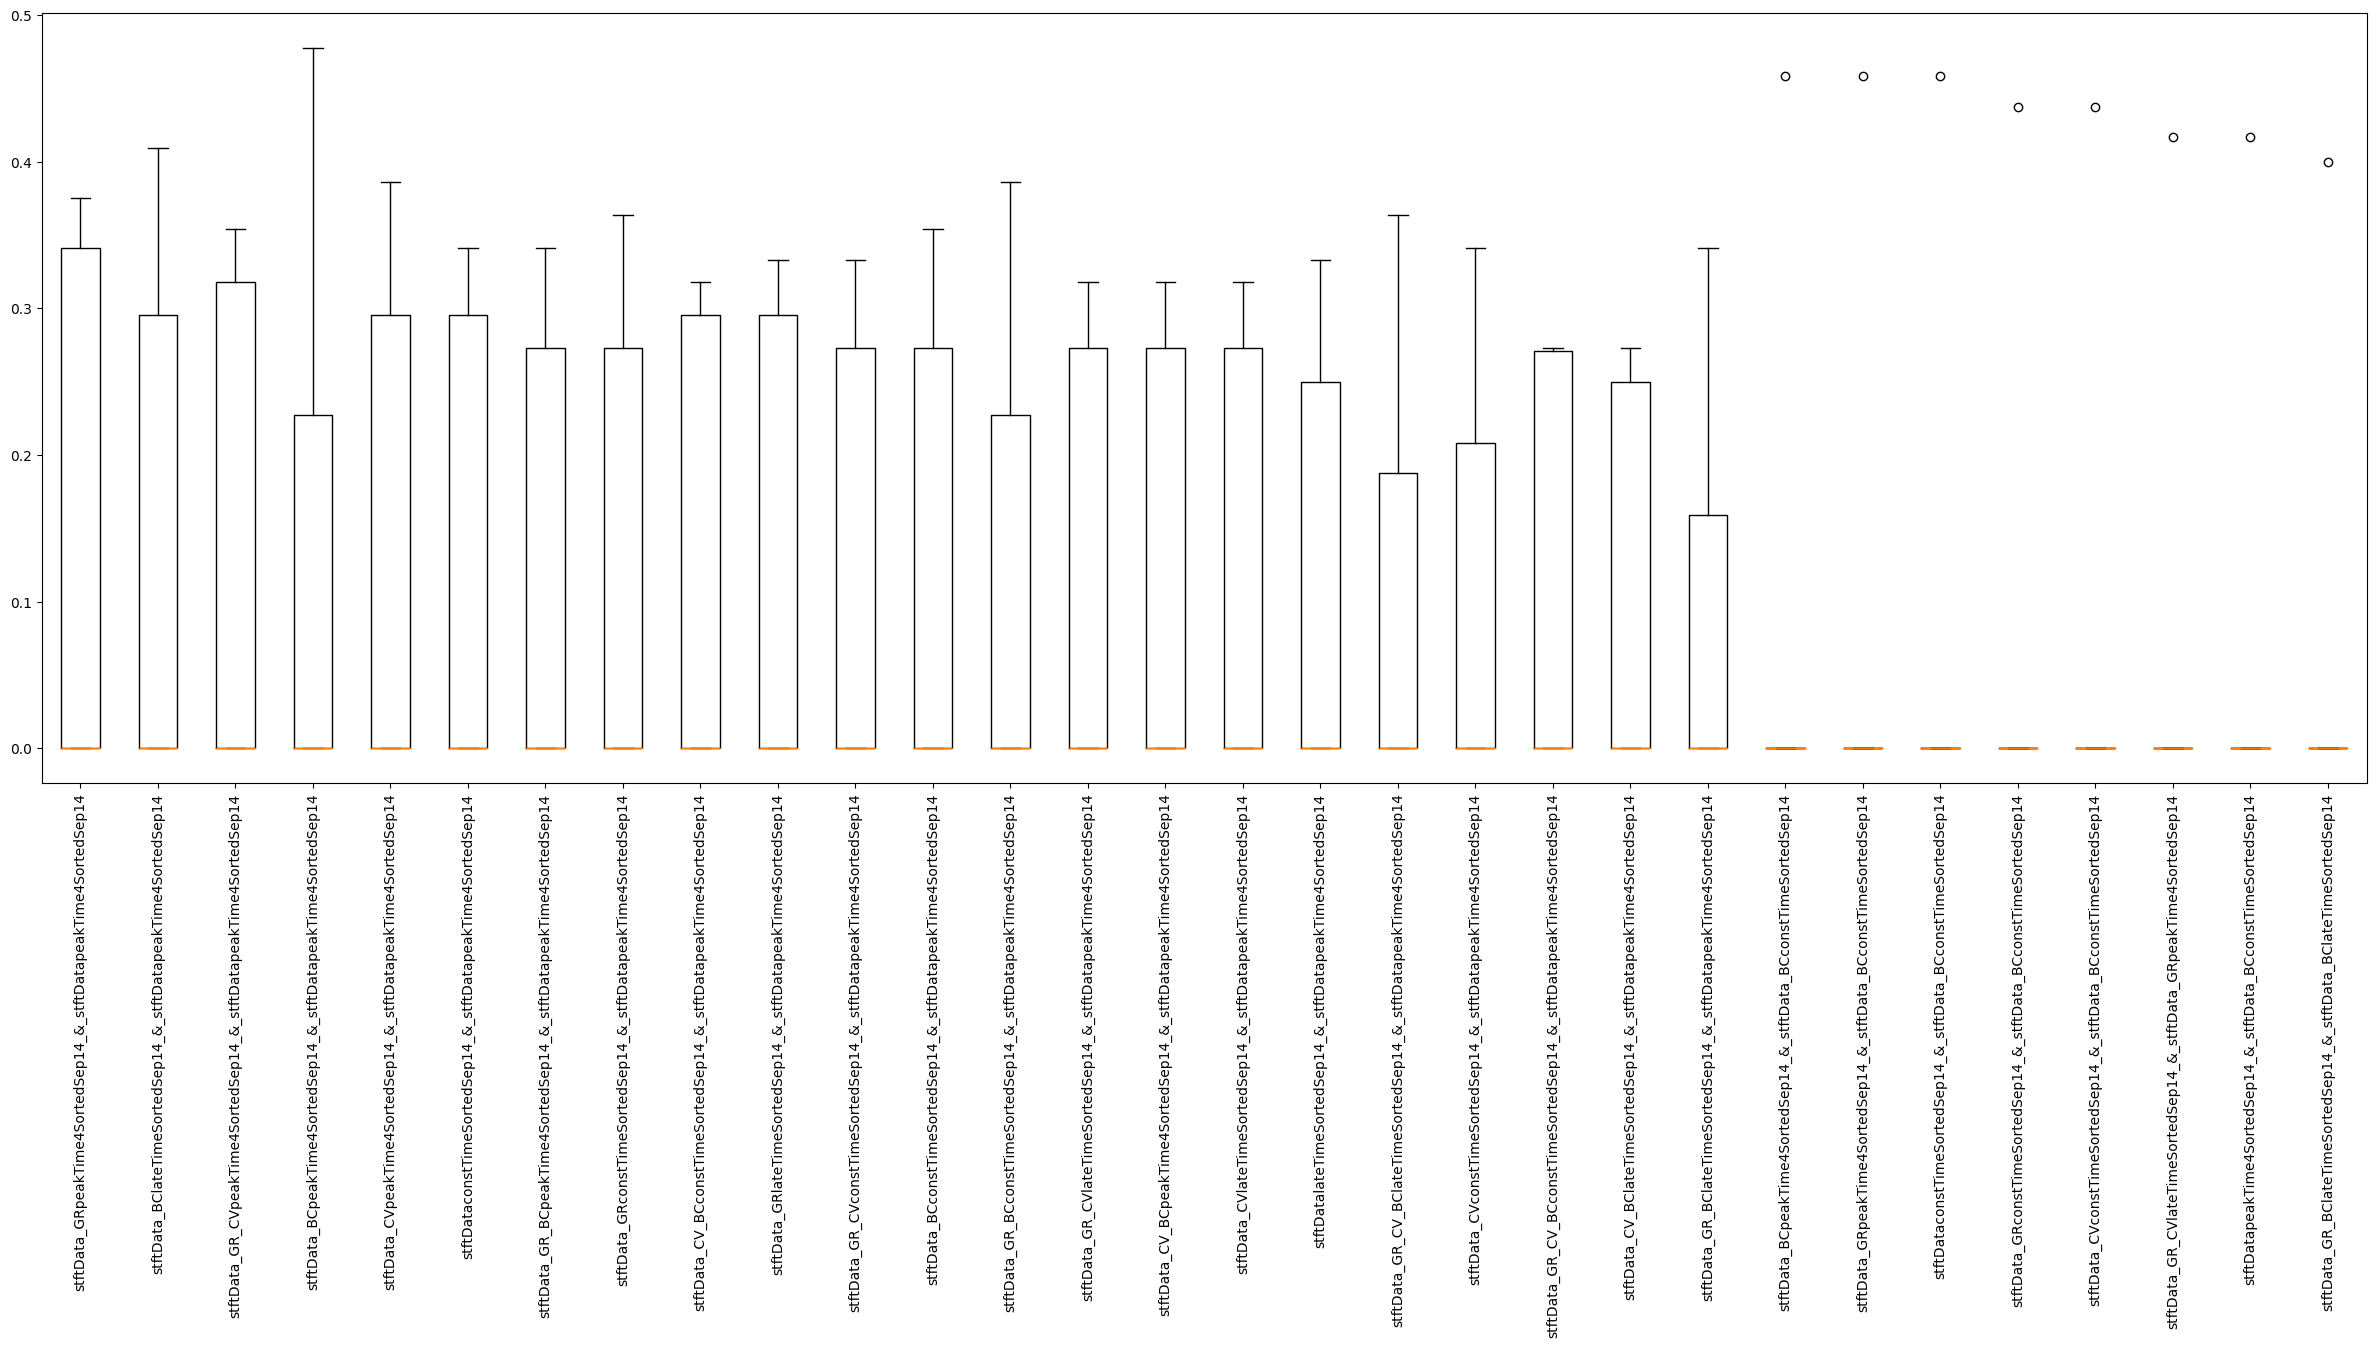

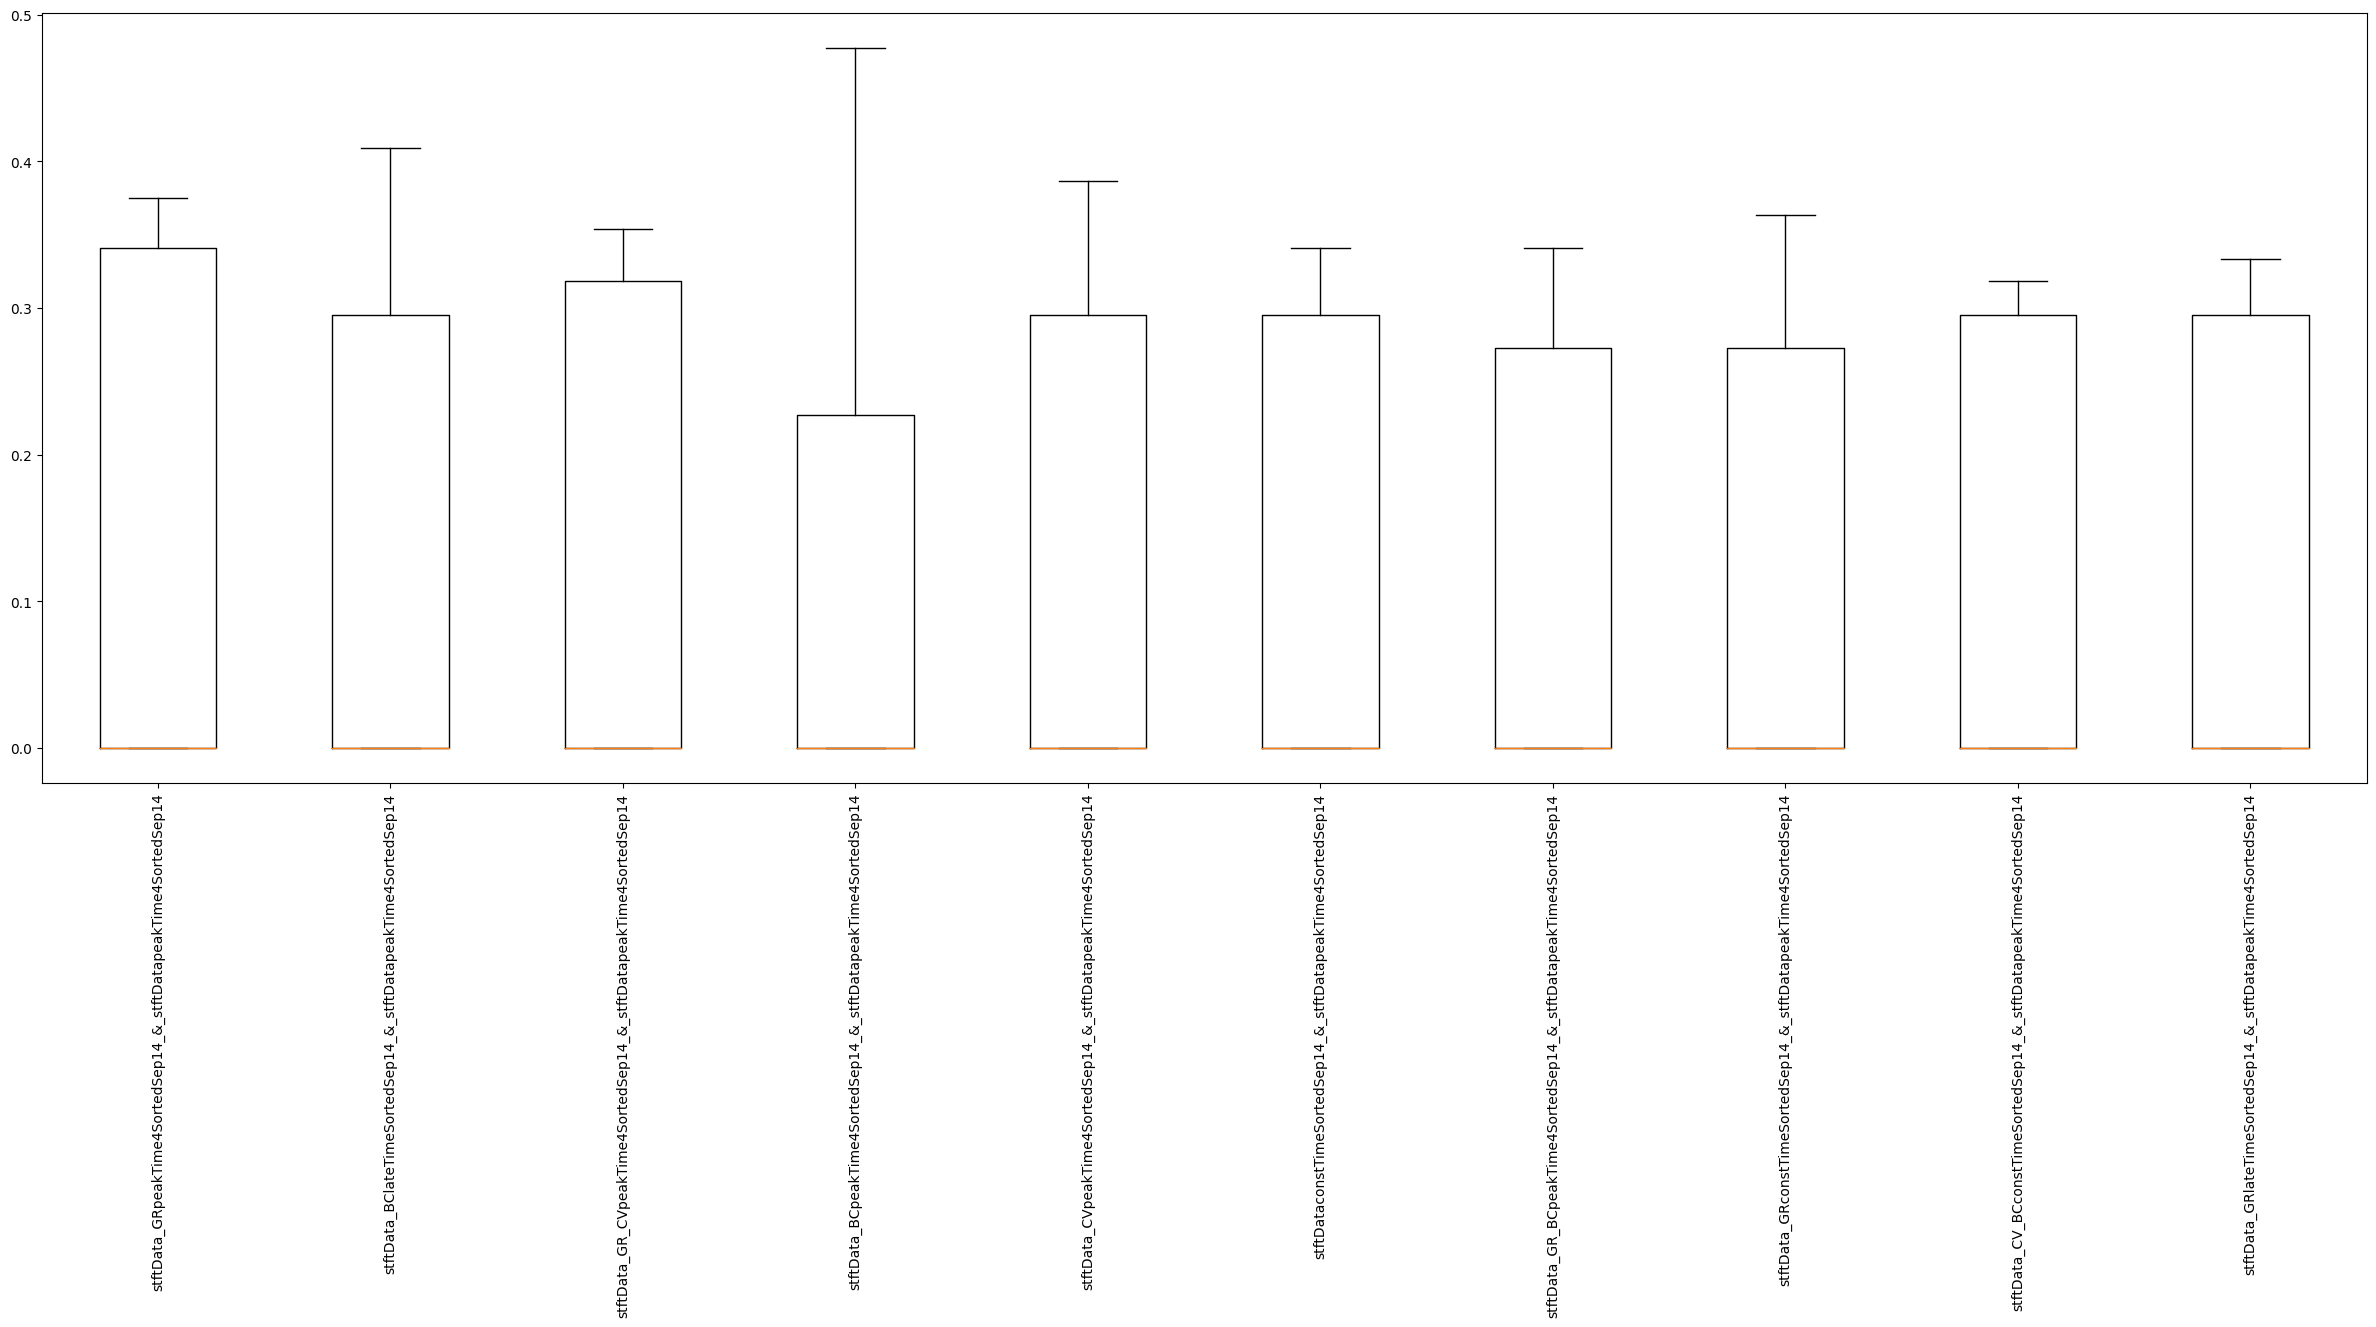

In [1151]:
import matplotlib.pyplot as plt
meanTop = np.mean(topPerFeature[1:], axis=0)
indices = np.argsort(meanTop, axis=0)[::-1]

print(indices.shape)
featCombos = np.array(featCombos)

if len(featCombos) < 30:
    plt.figure(figsize=[30,10])
    plt.boxplot(topPerFeature[1:, indices][:,:30])
    plt.xticks(np.arange(len(featCombos[indices][:30]))+1,featCombos[indices][:30],rotation=45)
    print("")
else: 
    plt.figure(figsize=[30,10])
    plt.boxplot(topPerFeature[1:, indices][:,:30])
    plt.xticks(np.arange(30)+1,featCombos[indices][:30],rotation=90)
    print("")
    plt.figure(figsize=[30,10])
    plt.boxplot(topPerFeature[1:, indices][:,:10])
    plt.xticks(np.arange(10)+1,featCombos[indices][:10],rotation=90)
    print("")
    


In [1152]:
print("Top ten highest accuracies")

topTen.reverse()
for top in topTen:
    print(
            f"Accuracy {round(top[0],2)} : subject {top[1]}, feature:{top[2]}, kernel{top[3]}, C:{top[4]}"
        )


Top ten highest accuracies
Accuracy 0.48 : subject 6, feature:stftData_BCpeakTime4SortedSep14_&_stftDatapeakTime4SortedSep14, kernelrbf, C:2.5
Accuracy 0.46 : subject 4, feature:stftDataconstTimeSortedSep14_&_stftData_BCconstTimeSortedSep14, kernellinear, C:2.5
Accuracy 0.46 : subject 4, feature:stftData_GRpeakTime4SortedSep14_&_stftData_BCconstTimeSortedSep14, kernelsigmoid, C:2.5
Accuracy 0.46 : subject 4, feature:stftData_BCpeakTime4SortedSep14_&_stftData_BCconstTimeSortedSep14, kernelsigmoid, C:2.5
Accuracy 0.44 : subject 4, feature:stftData_GRconstTimeSortedSep14_&_stftData_BCconstTimeSortedSep14, kernelsigmoid, C:2.5
Accuracy 0.44 : subject 4, feature:stftData_CVconstTimeSortedSep14_&_stftData_BCconstTimeSortedSep14, kernelrbf, C:2.5
Accuracy 0.44 : subject 4, feature:stftData_BCpeakTime4SortedSep14_&_stftData_BCconstTimeSortedSep14, kernellinear, C:2.5
Accuracy 0.43 : subject 6, feature:stftData_BCpeakTime4SortedSep14_&_stftDatapeakTime4SortedSep14, kernellinear, C:2.5
Accuracy 

In [1153]:
print("Top ten highest accuracies")
for subTop in topThreeAllSubjects:
    subTop.reverse()

Top ten highest accuracies


In [1154]:
#topThreeAllSubjects.sort(reverse=True)
arrayOfTopFeatureNames = []
for subTop in topThreeAllSubjects[1:]:
    print("")
    for top in subTop[:1]:
        arrayOfTopFeatureNames.append(top[2])
        print(
                f"Accuracy {round(top[0],2)} : subject {top[1]}, feature:{top[2]}, kernel{top[3]}, C:{top[4]}"
            )
# np.save(f"topFeaturesResults/{saveTopName}", topThreeAllSubjects[:-1])
arrayOfTopFeatureNames = np.array(arrayOfTopFeatureNames, dtype=object)
newArrayOfTopFeatureNames = []
for topNames in arrayOfTopFeatureNames:
    splitArray = []
    if "_&_" in topNames:
        splitArray = np.array(topNames.split("_&_"), dtype=object)
    else: 
        splitArray = [topNames]

    skip = False  
    if len(splitArray) < cmbSize:
        continue
    newArrayOfTopFeatureNames.append(splitArray)
    
print(newArrayOfTopFeatureNames)
newArrayOfTopFeatureNames = np.array(newArrayOfTopFeatureNames, dtype=object) 
if saveTopName is not None:
    np.save(f"topFeatures/{saveTopName}", newArrayOfTopFeatureNames)
    print("TopFeatureNameArraySaved")
    print(newArrayOfTopFeatureNames)


Accuracy 0.4 : subject 1, feature:stftData_GR_BClateTimeSortedSep14_&_stftData_BClateTimeSortedSep14, kernelrbf, C:2.5

Accuracy 0.38 : subject 2, feature:stftData_GRpeakTime4SortedSep14_&_stftDatapeakTime4SortedSep14, kernellinear, C:2.5

Accuracy 0.36 : subject 3, feature:stftData_GRpeakTime4SortedSep14_&_stftDatapeakTime4SortedSep14, kernellinear, C:2.5

Accuracy 0.46 : subject 4, feature:stftData_GRpeakTime4SortedSep14_&_stftData_BCconstTimeSortedSep14, kernelsigmoid, C:2.5

Accuracy 0.42 : subject 5, feature:stftData_GR_CVlateTimeSortedSep14_&_stftData_GRpeakTime4SortedSep14, kernelsigmoid, C:2.5

Accuracy 0.48 : subject 6, feature:stftData_BCpeakTime4SortedSep14_&_stftDatapeakTime4SortedSep14, kernelrbf, C:2.5

Accuracy nan : subject 7, feature:stftDatapeakTime4SortedSep14_&_stftData_BClateTimeSortedSep14, kernellinear, C:2.5

Accuracy nan : subject 8, feature:stftDatapeakTime4SortedSep14_&_stftData_BClateTimeSortedSep14, kernellinear, C:2.5

Accuracy nan : subject 9, feature:st

In [1155]:
topThreeAllSubjects.sort(reverse=True)
arrayOfTopFeatureNames = []
for subTop in topThreeAllSubjects[:-1]:
    print("")
    for top in subTop[:1]:
        arrayOfTopFeatureNames.append(top[2])
        print(
                f"Accuracy {round(top[0],2)} : subject {top[1]}, feature:{top[2]}, kernel{top[3]}, C:{top[4]}"
            )
np.save(f"topFeaturesResults/{saveTopName}", topThreeAllSubjects[:-1])
arrayOfTopFeatureNames = np.array(arrayOfTopFeatureNames, dtype=object)
newArrayOfTopFeatureNames = []
for topNames in arrayOfTopFeatureNames:
    splitArray = []
    if "_&_" in topNames:
        splitArray = np.array(topNames.split("_&_"), dtype=object)
    else: 
        splitArray = [topNames]

    skip = False  
    if len(splitArray) < cmbSize:
        continue
    newArrayOfTopFeatureNames.append(splitArray)
    
# print(newArrayOfTopFeatureNames)
# newArrayOfTopFeatureNames = np.array(newArrayOfTopFeatureNames, dtype=object) 
# if saveTopName is not None:
#     np.save(f"topFeatures/{saveTopName}", newArrayOfTopFeatureNames)
#     print("TopFeatureNameArraySaved")
#     print(newArrayOfTopFeatureNames)


Accuracy 0.48 : subject 6, feature:stftData_BCpeakTime4SortedSep14_&_stftDatapeakTime4SortedSep14, kernelrbf, C:2.5

Accuracy 0.46 : subject 4, feature:stftData_GRpeakTime4SortedSep14_&_stftData_BCconstTimeSortedSep14, kernelsigmoid, C:2.5

Accuracy 0.42 : subject 5, feature:stftData_GR_CVlateTimeSortedSep14_&_stftData_GRpeakTime4SortedSep14, kernelsigmoid, C:2.5

Accuracy 0.4 : subject 1, feature:stftData_GR_BClateTimeSortedSep14_&_stftData_BClateTimeSortedSep14, kernelrbf, C:2.5

Accuracy 0.38 : subject 2, feature:stftData_GRpeakTime4SortedSep14_&_stftDatapeakTime4SortedSep14, kernellinear, C:2.5

Accuracy 0.36 : subject 3, feature:stftData_GRpeakTime4SortedSep14_&_stftDatapeakTime4SortedSep14, kernellinear, C:2.5

Accuracy 0.0 : subject 0, feature:stftDatapeakTime4SortedSep14_&_stftData_BClateTimeSortedSep14, kernellinear, C:2.5

Accuracy nan : subject 7, feature:stftDatapeakTime4SortedSep14_&_stftData_BClateTimeSortedSep14, kernellinear, C:2.5

Accuracy nan : subject 8, feature:st

In [1156]:
subjAv = np.zeros(subjectResultArray.shape[0])
for s, subj in enumerate(subjectResultArray):
    subjAv[s] = 0
    if all(subj == None):
        continue
    subjAv[s] = np.mean(subj[np.where(subj != None)])
print(subjAv)
pd.set_option("display.max_columns", None)
table = pd.DataFrame(np.array(comboAverage), columns=headers)
display(table)

print(
    f"Max average accuracy {np.max(np.array(comboAverage[np.where(np.isnan(comboAverage)==False)]))}"
)
maxVal = np.max(np.array(comboAverage[np.where(np.isnan(comboAverage) == False)]))
maxInd = int(np.where(comboAverage == maxVal)[1][0])



[0.         0.24545455 0.26772388 0.24389417 0.34825871 0.25808458
 0.29545455        nan        nan        nan]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263
0,NaN,0.275,0.175,0.25,0.275,0.15,0.175,0.15,0.15,0.225,0.2,0.25,0.2,0.2,0.225,0.3,0.375,0.375,0.275,0.2,0.3,0.225,0.25,0.2,0.275,0.3,0.225,0.175,0.1,0.125,0.25,0.225,0.25,0.275,0.3,0.275,0.275,0.25,0.325,0.325,0.225,0.25,0.225,0.175,0.2,0.225,0.275,0.2,0.25,0.275,0.275,0.275,0.325,0.4,0.2,0.2,0.2,0.325,0.4,0.25,0.275,0.2,0.3,0.3,0.325,0.3,0.302399,0.324495,0.295455,0.30303,0.272096,0.301136,0.243687,0.256944,0.294192,0.352273,0.299874,0.330177,0.286616,0.300505,0.294192,0.322601,0.292298,0.316288,0.295455,0.294192,0.323232,0.299874,0.248737,0.307449,0.251894,0.236111,0.258838,0.271465,0.301136,0.219697,0.265783,0.234848,0.27904,0.265783,0.228535,0.294192,0.285354,0.25,0.286616,0.257576,0.213384,0.272096,0.292929,0.248106,0.262626,0.308712,0.280303,0.338384,0.251263,0.243056,0.27904,0.215278,0.243687,0.256944,0.271465,0.277778,0.292929,0.23548,0.208333,0.228535,0.243056,0.227273,0.270833,0.244949,0.207071,0.267045,0.395833,0.333333,0.416667,0.4375,0.354167,0.458333,0.333333,0.333333,0.3125,0.395833,0.333333,0.333333,0.416667,0.375,0.458333,0.354167,0.291667,0.333333,0.3125,0.354167,0.229167,0.458333,0.3125,0.395833,0.395833,0.4375,0.416667,0.3125,0.291667,0.333333,0.416667,0.416667,0.4375,0.375,0.25,0.375,0.333333,0.354167,0.395833,0.270833,0.270833,0.375,0.354167,0.291667,0.354167,0.395833,0.375,0.395833,0.291667,0.333333,0.291667,0.354167,0.270833,0.291667,0.354167,0.354167,0.395833,0.375,0.395833,0.395833,0.270833,0.25,0.333333,0.354167,0.3125,0.354167,0.1875,0.229167,0.270833,0.291667,0.3125,0.208333,0.229167,0.25,0.208333,0.270833,0.270833,0.291667,0.291667,0.270833,0.229167,0.229167,0.25,0.270833,0.270833,0.208333,0.270833,0.291667,0.270833,0.291667,0.25,0.208333,0.1875,0.145833,0.145833,0.270833,0.208333,0.208333,0.208333,0.270833,0.3125,0.270833,0.25,0.208333,0.291667,0.3125,0.208333,0.166667,0.25,0.333333,0.354167,0.291667,0.270833,0.291667,0.208333,0.208333,0.229167,0.354167,0.270833,0.333333,0.25,0.208333,0.229167,0.270833,0.25,0.270833,0.333333,0.291667,0.416667,0.354167,0.333333,0.395833


Max average accuracy 0.4583333333333333


In [1157]:
print("Based on combAverage")
#print(headers[comboAverage.argsort()[0][-5:][::-1]])
top5 = headers[comboAverage.argsort()[0][-5:][::-1]]
top5Vals = comboAverage[0][comboAverage.argsort()[0][-5:][::-1]]
for maxInd,res in zip(top5, top5Vals):
    #print(allCombinations[maxInd][0])
    print(allCombinations[maxInd][0])
    print(allCombinations[maxInd][1])
    print(res)
    print()

Based on combAverage
stftDatapeakTime4SortedSep14_&_stftData_BClateTimeSortedSep14
linear
nan

stftData_BCpeakTime4SortedSep14_&_stftData_BCconstTimeSortedSep14
sigmoid
0.4583333333333333

stftData_GRpeakTime4SortedSep14_&_stftData_BCconstTimeSortedSep14
sigmoid
0.4583333333333333

stftDataconstTimeSortedSep14_&_stftData_BCconstTimeSortedSep14
linear
0.4583333333333333

stftData_GRconstTimeSortedSep14_&_stftData_BCconstTimeSortedSep14
sigmoid
0.4375



In [1158]:
print("Based on combTotal")
top5 = headers[comboTotal.argsort()[0][-5:][::-1]]
top5Vals = comboTotal[0][comboTotal.argsort()[0][-5:][::-1]] /9
for maxInd,res in zip(top5, top5Vals):
    print(allCombinations[maxInd][0])
    print(allCombinations[maxInd][1])
    print(res)
    print()

Based on combTotal
stftDatapeakTime4SortedSep14_&_stftData_BClateTimeSortedSep14
linear
nan

stftData_GRpeakTime4SortedSep14_&_stftDatapeakTime4SortedSep14
linear
0.11742424242424243

stftData_BClateTimeSortedSep14_&_stftDatapeakTime4SortedSep14
sigmoid
0.1127946127946128

stftData_GRpeakTime4SortedSep14_&_stftDatapeakTime4SortedSep14
sigmoid
0.11005892255892255

stftData_BCpeakTime4SortedSep14_&_stftDatapeakTime4SortedSep14
rbf
0.10816498316498317



In [1159]:
table = pd.DataFrame(np.array(comboTotal), columns=headers)
display(table)

maxVal2 = np.max(np.array(comboTotal[np.where(np.isnan(comboTotal) == False)]))

for maxInd2 in np.where(comboTotal == maxVal2)[1]:
    print(headers[maxInd2])
    print(nrOfSubjects[maxInd2])
    print(
        f"Max total significant accuracy then averaged {maxVal2/nrOfSubjects[maxInd2]} "
    )
    print(allCombinations[maxInd2][0])
    print(allCombinations[maxInd2][1])
    print(f"C: {allCombinations[maxInd2][2]} ")


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263
0,NaN,0.275,0.175,0.25,0.275,0.15,0.175,0.15,0.15,0.225,0.2,0.25,0.2,0.2,0.225,0.3,0.375,0.375,0.275,0.2,0.3,0.225,0.25,0.2,0.275,0.3,0.225,0.175,0.1,0.125,0.25,0.225,0.25,0.275,0.3,0.275,0.275,0.25,0.325,0.325,0.225,0.25,0.225,0.175,0.2,0.225,0.275,0.2,0.25,0.275,0.275,0.275,0.325,0.4,0.2,0.2,0.2,0.325,0.4,0.25,0.275,0.2,0.3,0.3,0.325,0.3,0.907197,0.973485,0.886364,0.909091,0.816288,0.903409,0.731061,0.770833,0.882576,1.056818,0.899621,0.99053,0.859848,0.901515,0.882576,0.967803,0.876894,0.948864,0.886364,0.882576,0.969697,0.899621,0.746212,0.922348,0.755682,0.708333,0.776515,0.814394,0.903409,0.659091,0.797348,0.704545,0.837121,0.797348,0.685606,0.882576,0.856061,0.75,0.859848,0.772727,0.640152,0.816288,0.878788,0.744318,0.787879,0.926136,0.840909,1.015152,0.753788,0.729167,0.837121,0.645833,0.731061,0.770833,0.814394,0.833333,0.878788,0.706439,0.625,0.685606,0.729167,0.681818,0.8125,0.734848,0.621212,0.801136,0.395833,0.333333,0.416667,0.4375,0.354167,0.458333,0.333333,0.333333,0.3125,0.395833,0.333333,0.333333,0.416667,0.375,0.458333,0.354167,0.291667,0.333333,0.3125,0.354167,0.229167,0.458333,0.3125,0.395833,0.395833,0.4375,0.416667,0.3125,0.291667,0.333333,0.416667,0.416667,0.4375,0.375,0.25,0.375,0.333333,0.354167,0.395833,0.270833,0.270833,0.375,0.354167,0.291667,0.354167,0.395833,0.375,0.395833,0.291667,0.333333,0.291667,0.354167,0.270833,0.291667,0.354167,0.354167,0.395833,0.375,0.395833,0.395833,0.270833,0.25,0.333333,0.354167,0.3125,0.354167,0.1875,0.229167,0.270833,0.291667,0.3125,0.208333,0.229167,0.25,0.208333,0.270833,0.270833,0.291667,0.291667,0.270833,0.229167,0.229167,0.25,0.270833,0.270833,0.208333,0.270833,0.291667,0.270833,0.291667,0.25,0.208333,0.1875,0.145833,0.145833,0.270833,0.208333,0.208333,0.208333,0.270833,0.3125,0.270833,0.25,0.208333,0.291667,0.3125,0.208333,0.166667,0.25,0.333333,0.354167,0.291667,0.270833,0.291667,0.208333,0.208333,0.229167,0.354167,0.270833,0.333333,0.25,0.208333,0.229167,0.270833,0.25,0.270833,0.333333,0.291667,0.416667,0.354167,0.333333,0.395833


75
3.0
Max total significant accuracy then averaged 0.3522727272727273 
stftData_GRpeakTime4SortedSep14_&_stftDatapeakTime4SortedSep14
linear
C: 2.5 


In [1160]:
for names in featCombos:
    print(names)



stftDatapeakTime4SortedSep14_&_stftData_BClateTimeSortedSep14
stftData_BCpeakTime4SortedSep14_&_stftData_BClateTimeSortedSep14
stftData_CVpeakTime4SortedSep14_&_stftData_BClateTimeSortedSep14
stftData_CV_BCpeakTime4SortedSep14_&_stftData_BClateTimeSortedSep14
stftData_GRpeakTime4SortedSep14_&_stftData_BClateTimeSortedSep14
stftData_GR_BCpeakTime4SortedSep14_&_stftData_BClateTimeSortedSep14
stftData_GR_CVpeakTime4SortedSep14_&_stftData_BClateTimeSortedSep14
stftDataconstTimeSortedSep14_&_stftData_BClateTimeSortedSep14
stftData_BCconstTimeSortedSep14_&_stftData_BClateTimeSortedSep14
stftData_CVconstTimeSortedSep14_&_stftData_BClateTimeSortedSep14
stftData_CV_BCconstTimeSortedSep14_&_stftData_BClateTimeSortedSep14
stftData_GRconstTimeSortedSep14_&_stftData_BClateTimeSortedSep14
stftData_GR_BCconstTimeSortedSep14_&_stftData_BClateTimeSortedSep14
stftData_GR_CVconstTimeSortedSep14_&_stftData_BClateTimeSortedSep14
stftData_GR_CV_BCconstTimeSortedSep14_&_stftData_BClateTimeSortedSep14
stftDat